Analyze 21/0-11 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

## 21/0 -- LYN27A

In [21]:
# Load data into dicts and plot 
titles = ["K27A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 0
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 0
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/0/0_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/0/0_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/0/0_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/0/0_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [22]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

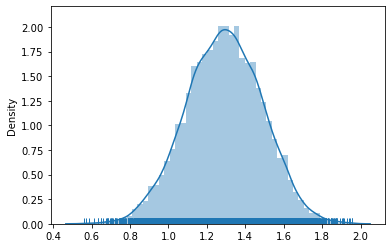

In [23]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [24]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [25]:
output_kcalmol

[0.77, (0.54, 0.99)]

In [26]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [27]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

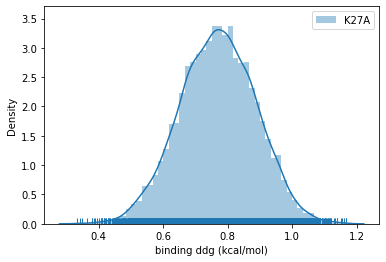

In [28]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/1 -- ASH39A

In [29]:
# Load data into dicts and plot 
titles = ["D39A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 1
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 1
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/1/1_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/1/1_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/1/1_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/1/1_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [30]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

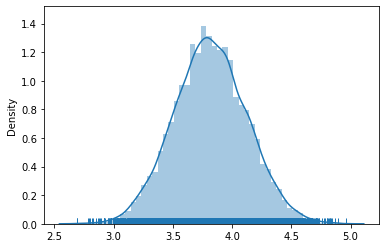

In [31]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [32]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [33]:
output_kcalmol

[2.28, (1.92, 2.64)]

In [34]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [35]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

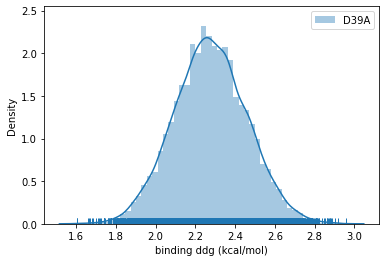

In [36]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/2 -- T42A

In [4]:
# Load data into dicts and plot 
titles = ["T42A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 2
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 2
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/2/2_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/2/2_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/2/2_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/2/2_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [6]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

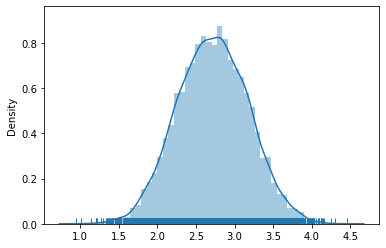

In [7]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [8]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [9]:
output_kcalmol

[1.62, (1.09, 2.16)]

In [10]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [11]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

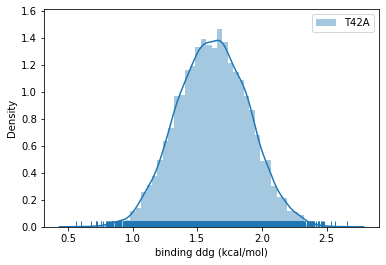

In [12]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/3 -- Y29A (1200 K, 0.4 nm radius, 24 replicas)

In [13]:
# Load data into dicts and plot 
titles = ["Y29A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 3
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 3
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/3/3_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/3/3_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/3/3_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/3/3_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [14]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

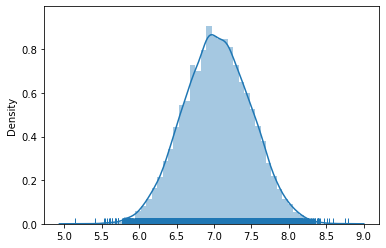

In [15]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [16]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [17]:
output_kcalmol

[4.2, (3.68, 4.72)]

In [18]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [19]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

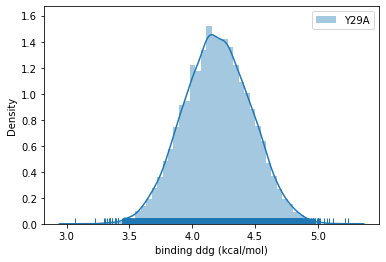

In [20]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/4 -- Y29A (1200 K, 0.3 nm radius, 24 replicas)

In [3]:
# Load data into dicts and plot 
titles = ["Y29A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 4
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 4
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/4/4_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/4/4_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/4/4_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/4/4_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [4]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

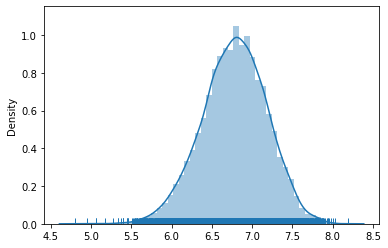

In [5]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[4.04, (3.55, 4.49)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

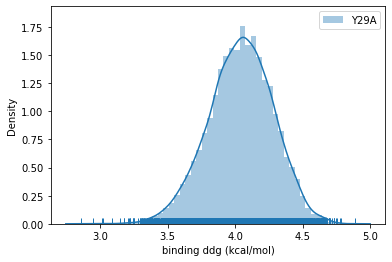

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/5 -- K27A (1200 K, 0.4 nm radius, 24 replicas)

In [4]:
# Load data into dicts and plot 
titles = ["K27A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 5
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 5
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/5/5_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/5/5_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/5/5_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/5/5_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [4]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

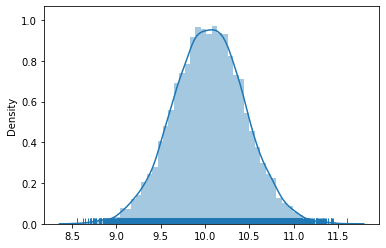

In [5]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[5.99, (5.51, 6.46)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [6]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [7]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.2432125837502206

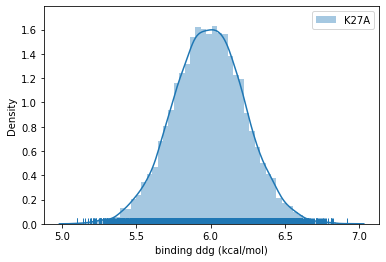

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/6 -- D39A (1200 K, 0.4 nm radius, 24 replicas)

In [14]:
# Load data into dicts and plot 
titles = ["D39A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 6
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 6
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/6/6_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/6/6_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/6/6_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/6/6_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [4]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

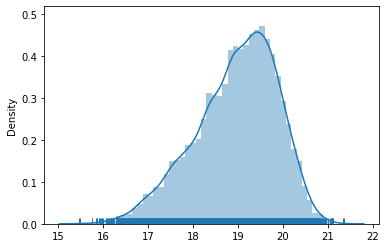

In [5]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[11.3, (10.1, 12.17)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [15]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [9]:
dgs_apo = np.array([l['apo'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_apo), np.std(dgs_apo)

(-5.336238387423816, 0.07466483559057933)

In [16]:
dgs_complex = np.array([l['complex'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_complex), np.std(dgs_complex)

(5.967510656261506, 0.5351211733140132)

In [12]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.5411525998853739

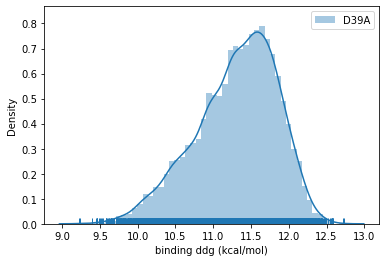

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/7 -- H102A (1200 K, 0.4 nm radius, 24 replicas)

In [3]:
# Load data into dicts and plot 
titles = ["H102A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 7
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 7
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/7/7_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/7/7_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/7/7_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/7/7_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [12]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

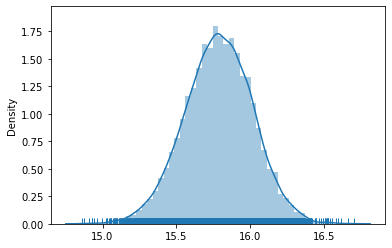

In [13]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [14]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [15]:
output_kcalmol

[9.41, (9.13, 9.68)]

In [16]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [4]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [5]:
dgs_apo = np.array([l['apo'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_apo), np.std(dgs_apo)

(-72.76790408861737, 0.06780925578088294)

In [6]:
dgs_complex = np.array([l['complex'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_complex), np.std(dgs_complex)

(-63.356520103010055, 0.12091488115765685)

In [18]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.13780506512641316

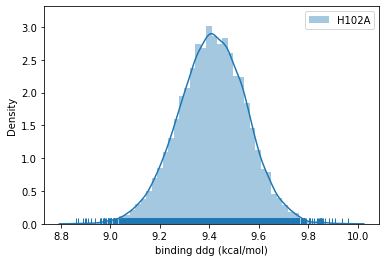

In [18]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/8 -- LYN27A (with LYS in PDB) (1200 K, 0.4 nm radius, 24 replicas)

In [35]:
# Load data into dicts and plot 
titles = ["K27A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 8
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 8
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/8/8_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/8/8_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/8/8_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/8/8_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [36]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

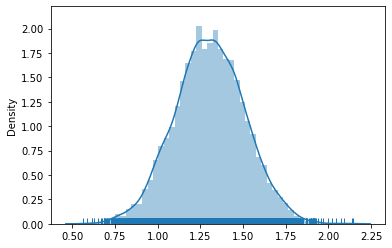

In [37]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [38]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [39]:
output_kcalmol

[0.78, (0.54, 1.02)]

In [40]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [41]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

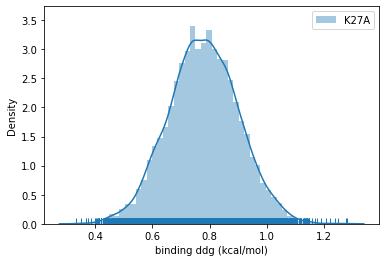

In [42]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/9 -- ASH39A (with ASP in PDB) (1200 K, 0.4 nm radius, 24 replicas)

In [10]:
# Load data into dicts and plot 
titles = ["D39A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 9
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 9
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/9/9_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/9/9_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/9/9_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/9/9_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [44]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

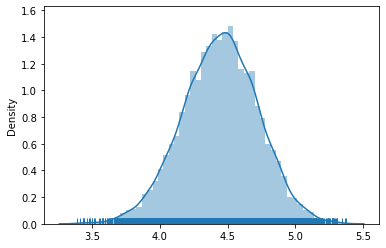

In [45]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [46]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [47]:
output_kcalmol

[2.65, (2.31, 2.97)]

In [48]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [49]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [11]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [12]:
dgs_apo = np.array([l['apo'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_apo), np.std(dgs_apo)

(42.51990814281092, 0.05255732547160602)

In [13]:
dgs_complex = np.array([l['complex'][0]*KT_KCALMOL for l in dgs_phase[forward]])
np.mean(dgs_complex), np.std(dgs_complex)

(45.169613937550906, 0.15895731856650386)

In [15]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.16705770126972602

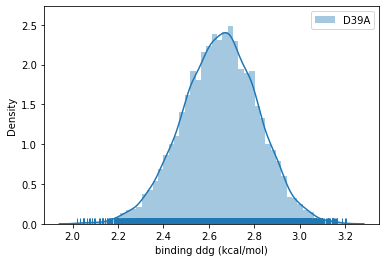

In [50]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/10 -- R83Q (1200 K, 0.4 nm radius, 24 replicas)

In [19]:
# Load data into dicts and plot 
titles = ["R83Q"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 10
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 10
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/10/10_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/10/10_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/10/10_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/10/10_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [20]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

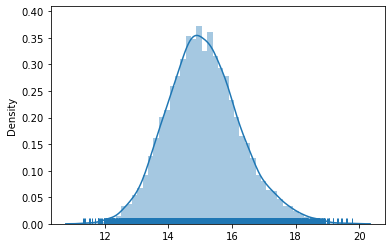

In [21]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [22]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [23]:
output_kcalmol

[9.01, (7.72, 10.52)]

In [24]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

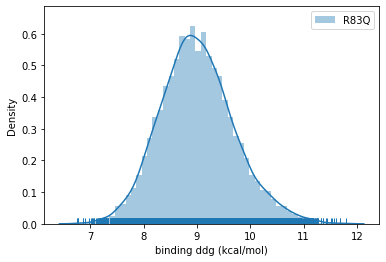

In [26]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 21/11 -- R87A (1200 K, 0.4 nm radius, 24 replicas)

In [4]:
# Load data into dicts and plot 
titles = ["R87A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 21
forward = 11
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 11
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/11/11_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/11/11_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/11/11_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/21/11/11_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 4.,  4., 17., 16., 12., 19., 15.,  7.,  5.,  1.]),
 array([121.93221559, 125.89562549, 129.85903539, 133.82244528,
        137.78585518, 141.74926508, 145.71267498, 149.67608488,
        153.63949477, 157.60290467, 161.56631457]),
 <BarContainer object of 10 artists>)

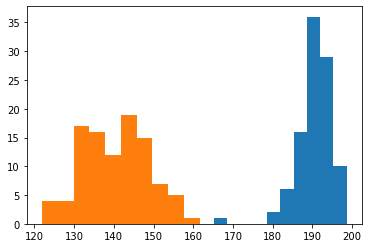

In [5]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [6]:
for i, work in enumerate(d_works['complex']['forward']):
    if work < 170:
        print(i, work)

89 165.22628604921405


In [10]:
d_works['complex']['reverse'][89]*-1

127.1760550142896

(array([ 2.,  0.,  1.,  0.,  2.,  4., 23., 34., 28.,  6.]),
 array([ 63.8223436 ,  71.88833038,  79.95431715,  88.02030393,
         96.0862907 , 104.15227748, 112.21826425, 120.28425103,
        128.35023781, 136.41622458, 144.48221136]),
 <BarContainer object of 10 artists>)

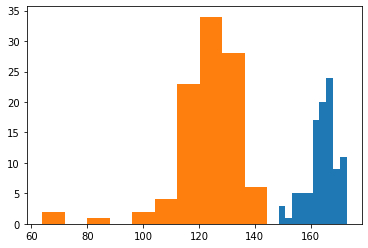

In [7]:
plt.hist(d_works['apo']['forward'])
plt.hist(d_works['apo']['reverse']*-1)

In [8]:
for i, work in enumerate(d_works['apo']['forward']):
    if work < 150:
        print(i, work)

66 148.48544157530236
97 149.35971494511267


In [9]:
d_works['apo']['reverse'][66]*-1

127.18732918265147

In [28]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

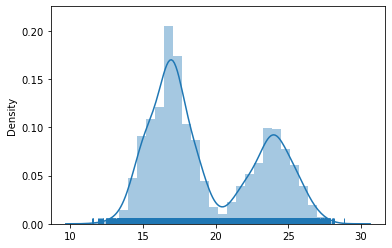

In [29]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [30]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [31]:
output_kcalmol

[11.55, (8.51, 15.58)]

In [32]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [33]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

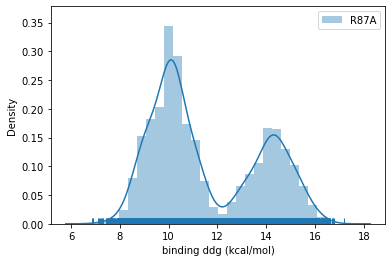

In [34]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()